In [12]:
# First we import packages we need, and scrape the data as the example shows
import sqlite3
import pandas as pd
import numpy as np

sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

salary_query = "SELECT teamID, yearID, sum(salary) as total_payroll FROM Salaries GROUP BY teamID, yearID ORDER BY teamID"
team_salaries = pd.read_sql(salary_query, conn)

# Part 1 -- Problem 1
# 1. Read winning information needed to compute winning rates with additional information like franchID from the database
# 2. Use "inner" merge to get rid of missing data and combine the salaries table with winning rates 
# 3. Relations between total_payroll and winning percents can be easily seen on the table.

win_percent_query = "SELECT teamID, yearID, 100*CAST(sum(W) AS float)/(sum(W)+sum(L)) as 'win_percent', \
                 sum(W) as all_wins, sum(W)+sum(L) as all_games, franchID FROM teams GROUP BY teamID, yearID ORDER BY teamID"
team_win_percents = pd.read_sql(win_percent_query, conn)

relations = team_salaries.merge(team_win_percents, how = "inner")

relations

,teamID,yearID,total_payroll,win_percent,all_wins,all_games,franchID
0,ANA,1997,31135472.0,51.851852,84,162,ANA
1,ANA,1998,41281000.0,52.469136,85,162,ANA
2,ANA,1999,55388166.0,43.209877,70,162,ANA
3,ANA,2000,51464167.0,50.617284,82,162,ANA
4,ANA,2001,47535167.0,46.296296,75,162,ANA
...,...,...,...,...,...,...,...
853,WAS,2010,61400000.0,42.592593,69,162,WSN
854,WAS,2011,63856928.0,49.689441,80,161,WSN
855,WAS,2012,80855143.0,60.493827,98,162,WSN
856,WAS,2013,113703270.0,53.086420,86,162,WSN


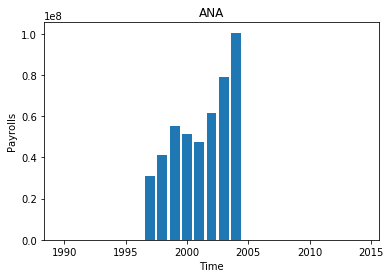

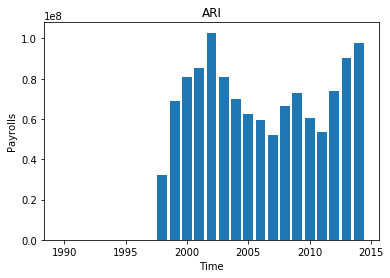

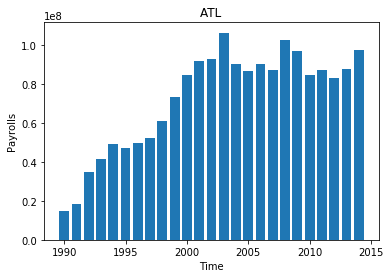

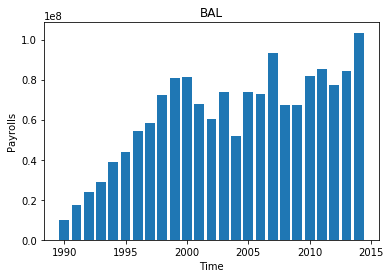

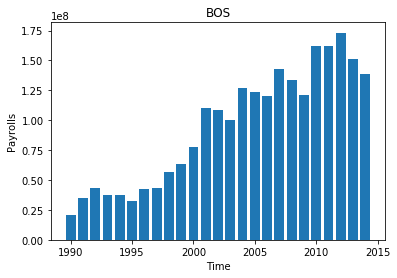

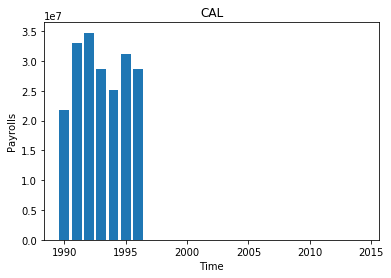

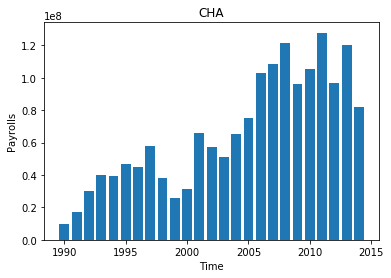

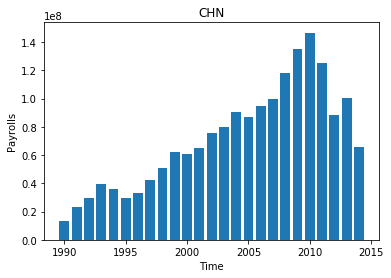

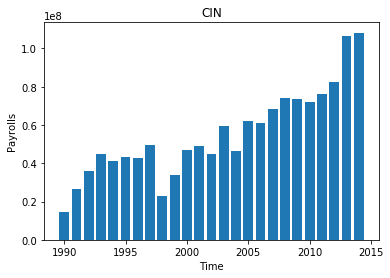

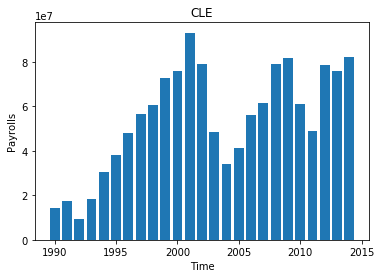

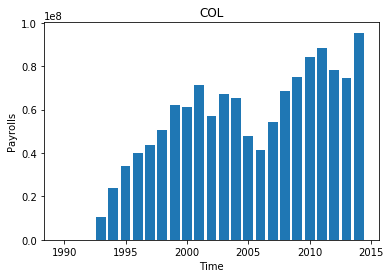

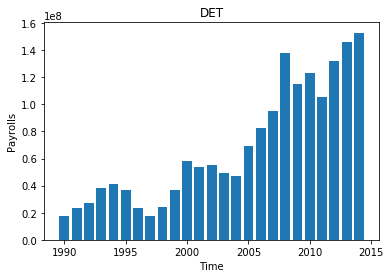

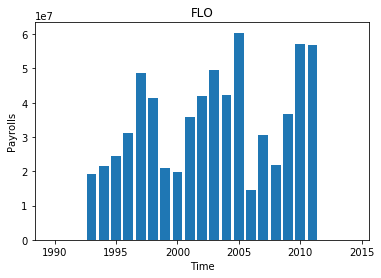

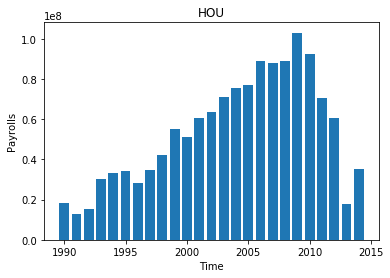

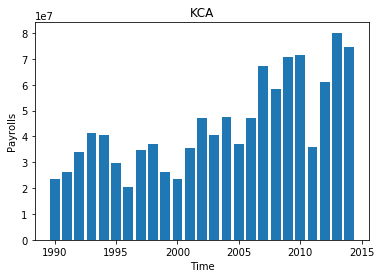

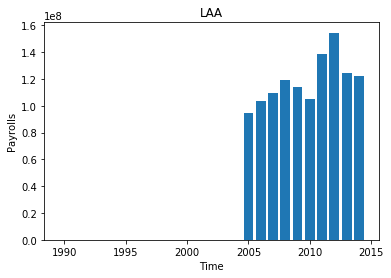

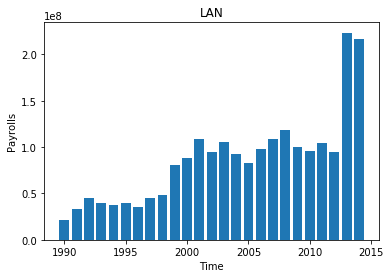

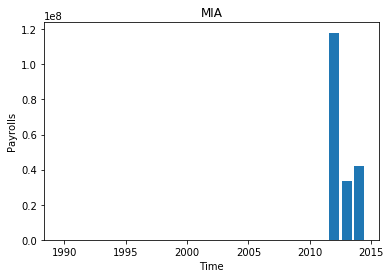

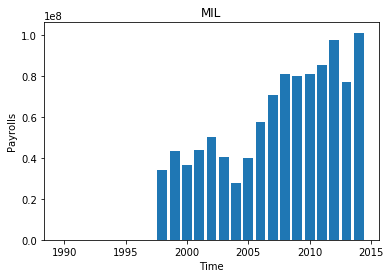

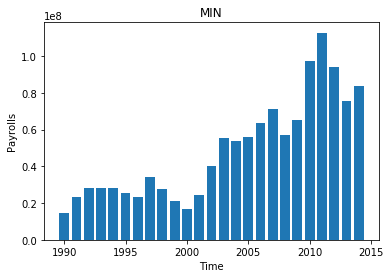

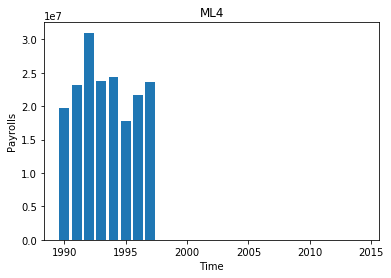

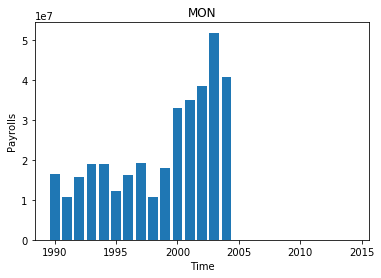

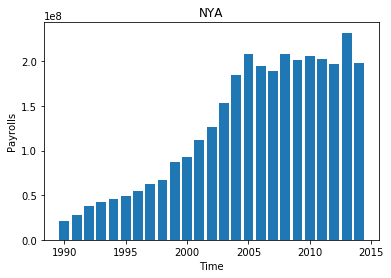

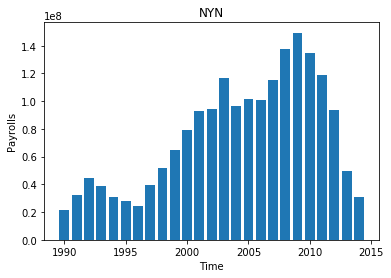

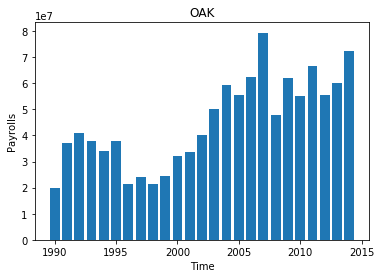

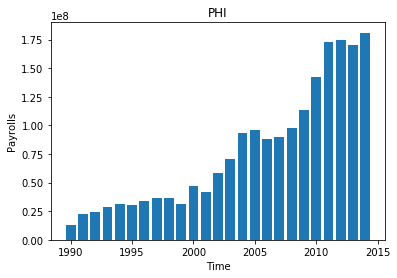

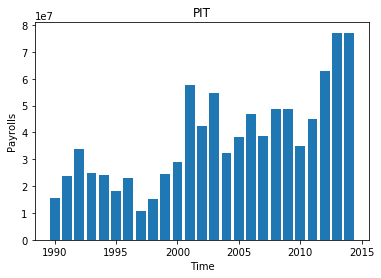

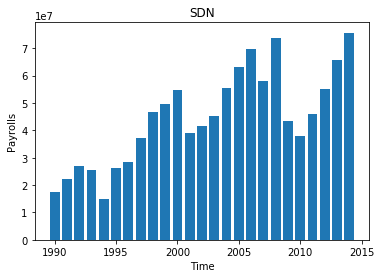

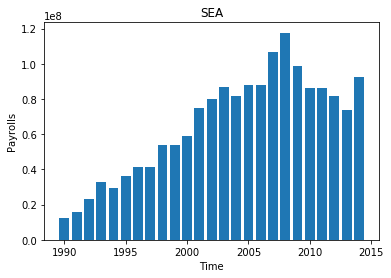

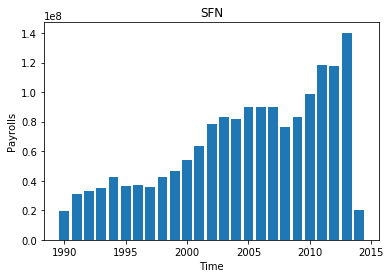

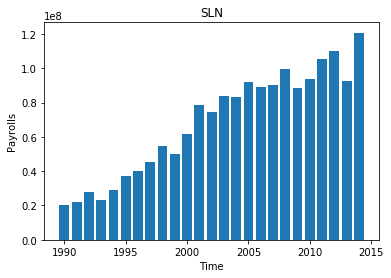

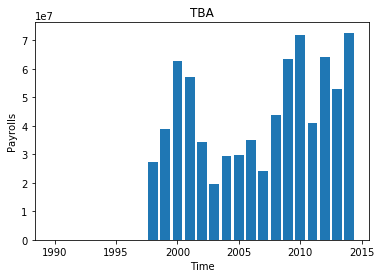

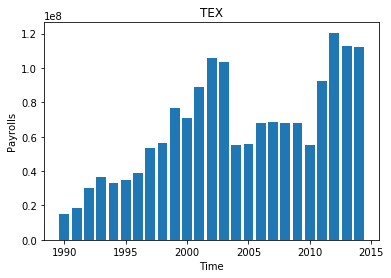

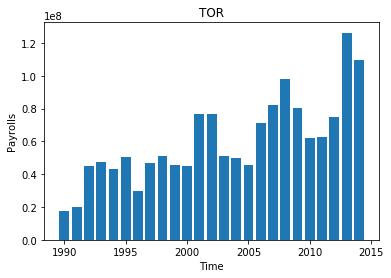

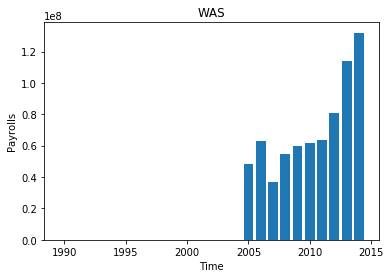

In [13]:
# Part2
import matplotlib.pyplot as pyplot

# Problem 2
# 1. Use unique to get the list of all teams and then plot data of each team.
# 2. Itearate through the list to get data from 1990-2014


teams = np.unique(relations.iloc[:,0].values)

for t in teams:
    team_info = relations.groupby(['teamID']).get_group(t)
    years = pd.DataFrame({'yearID': range(1990,2015)})
    team_payroll = years.merge(team_info, how = "left", left_on = ['yearID'], right_on = ['yearID'])
    
    pyplot.bar(team_payroll['yearID'], team_payroll['total_payroll'].fillna(value = 0))
    pyplot.xlabel("Time")
    pyplot.ylabel("Payrolls")
    pyplot.title(t)
    pyplot.show()
    
    
# Question 1
# From the graph we can see that generally payroll has a tendency of increasing over time.

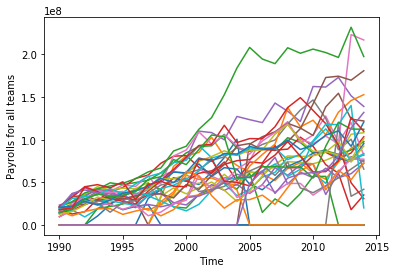

In [14]:
# Problem 3
# The following graph and code show that there is a tendency of increasing in payrolls on time.

for t in teams:
    team_info = relations.groupby(['teamID']).get_group(t)
    years = pd.DataFrame({'yearID': range(1990,2015)})
    team_payroll = years.merge(team_info, how = "left", left_on = ['yearID'], right_on = ['yearID']) 
    pyplot.plot(team_payroll['yearID'], team_payroll['total_payroll'].fillna(value = 0))

pyplot.xlabel("Time");
pyplot.ylabel("Payrolls for all teams");    

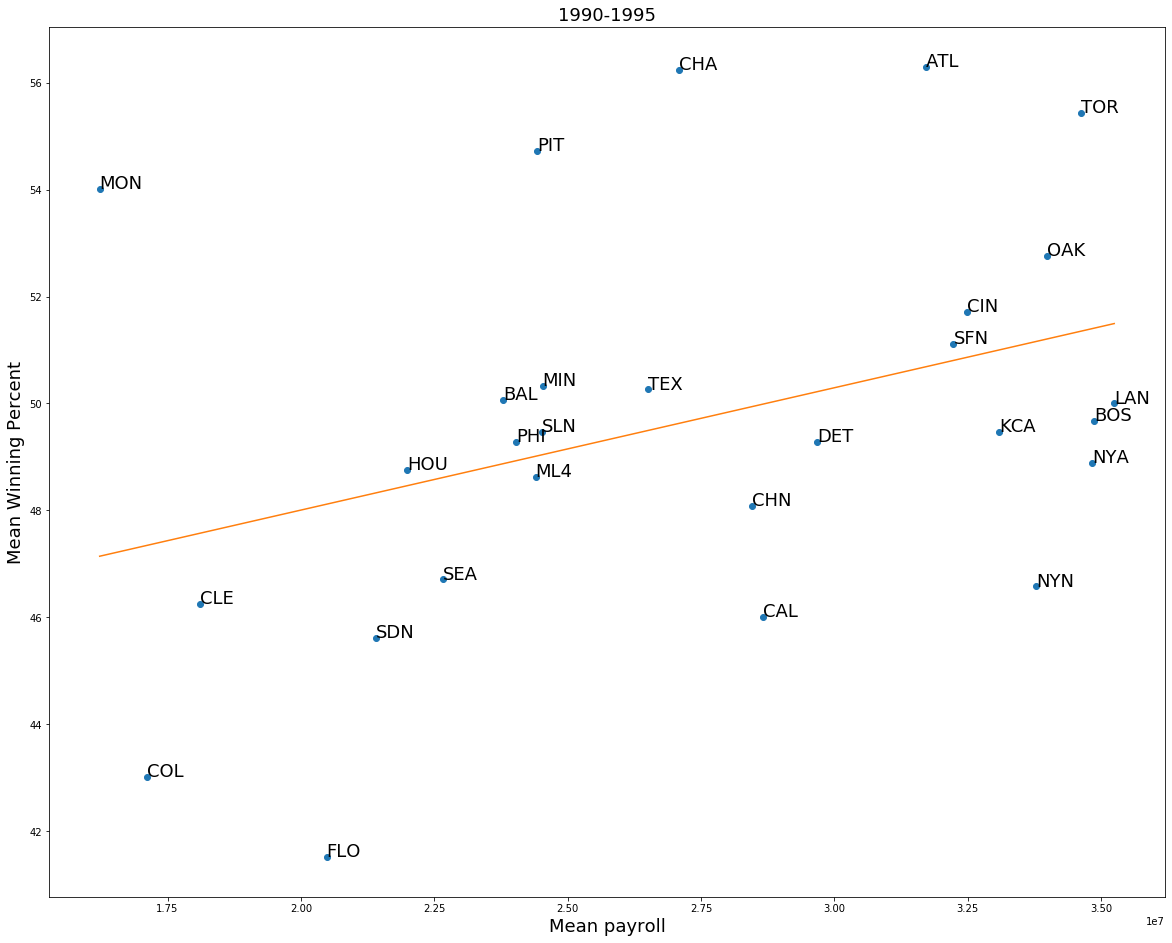

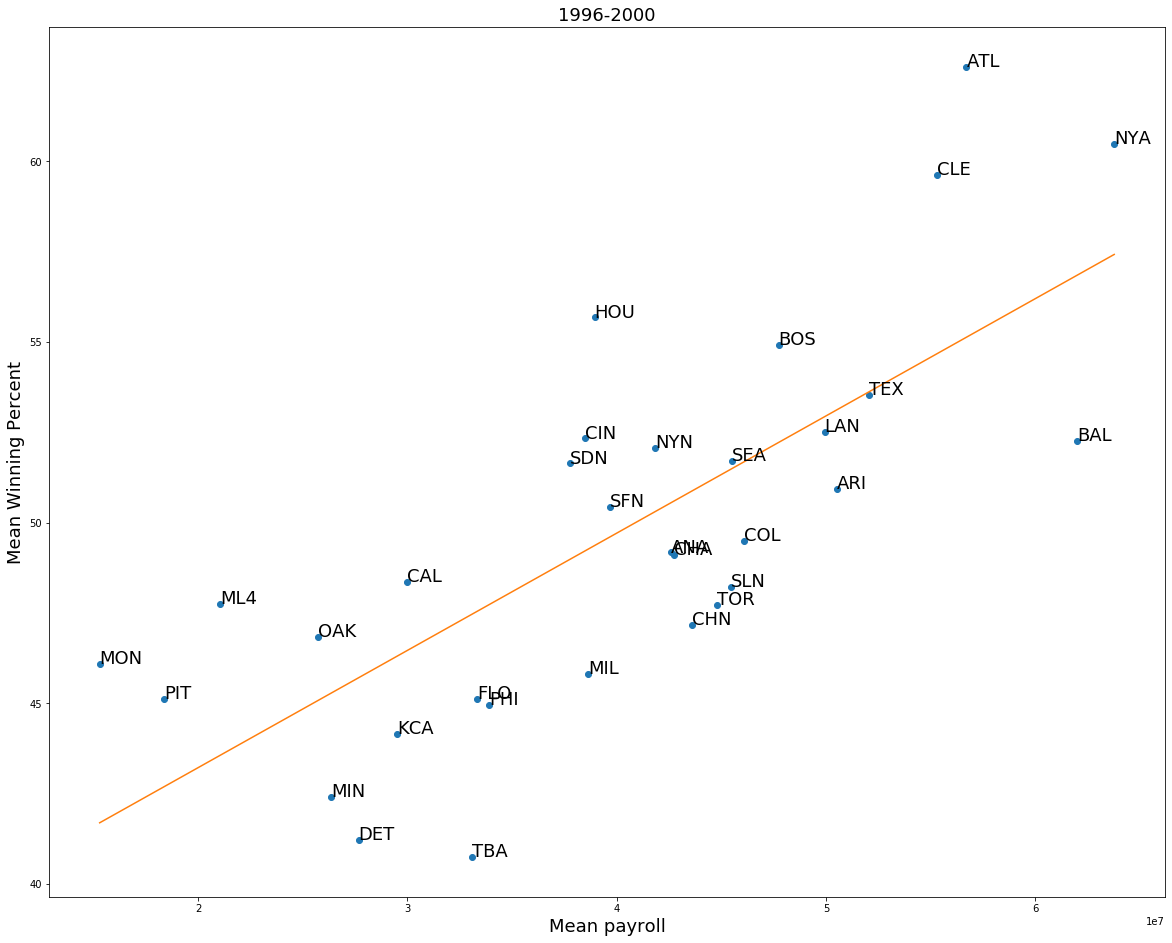

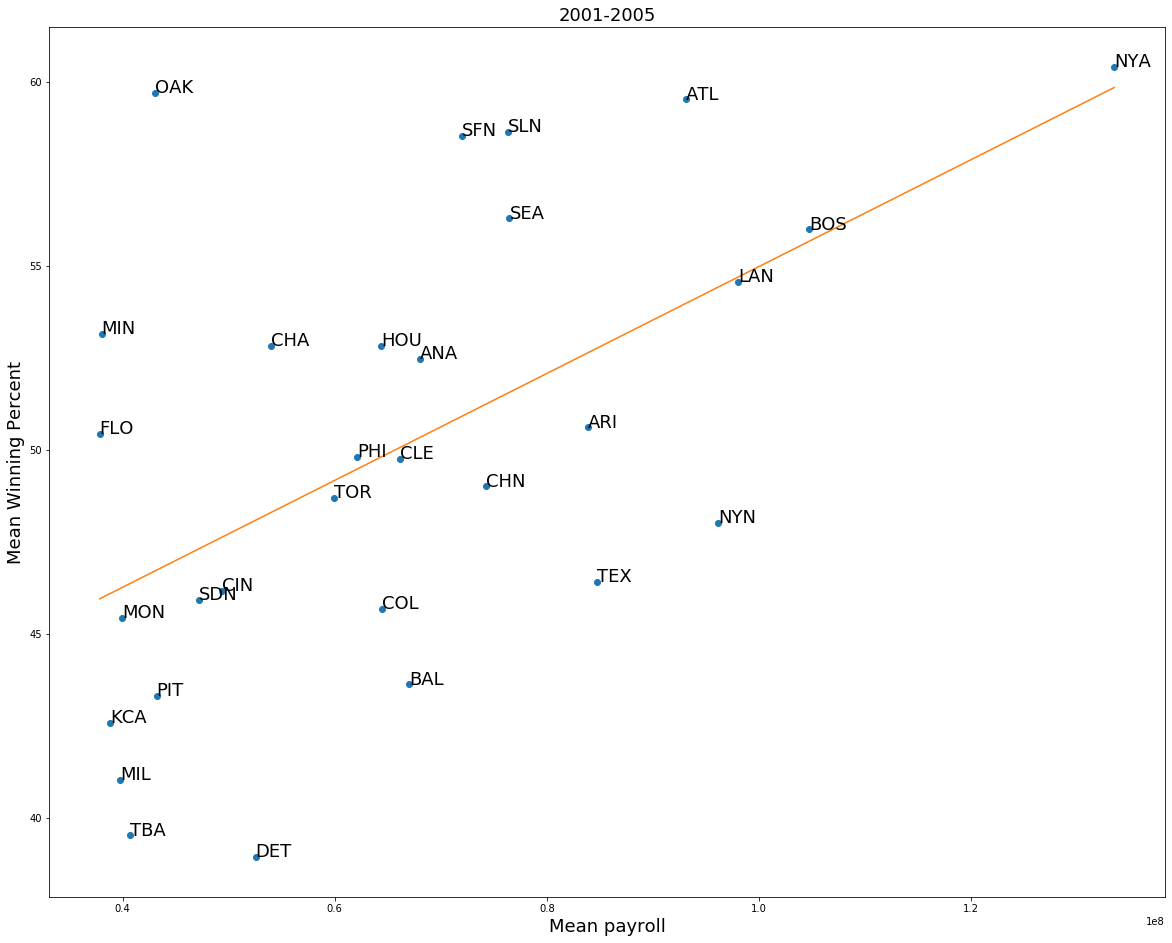

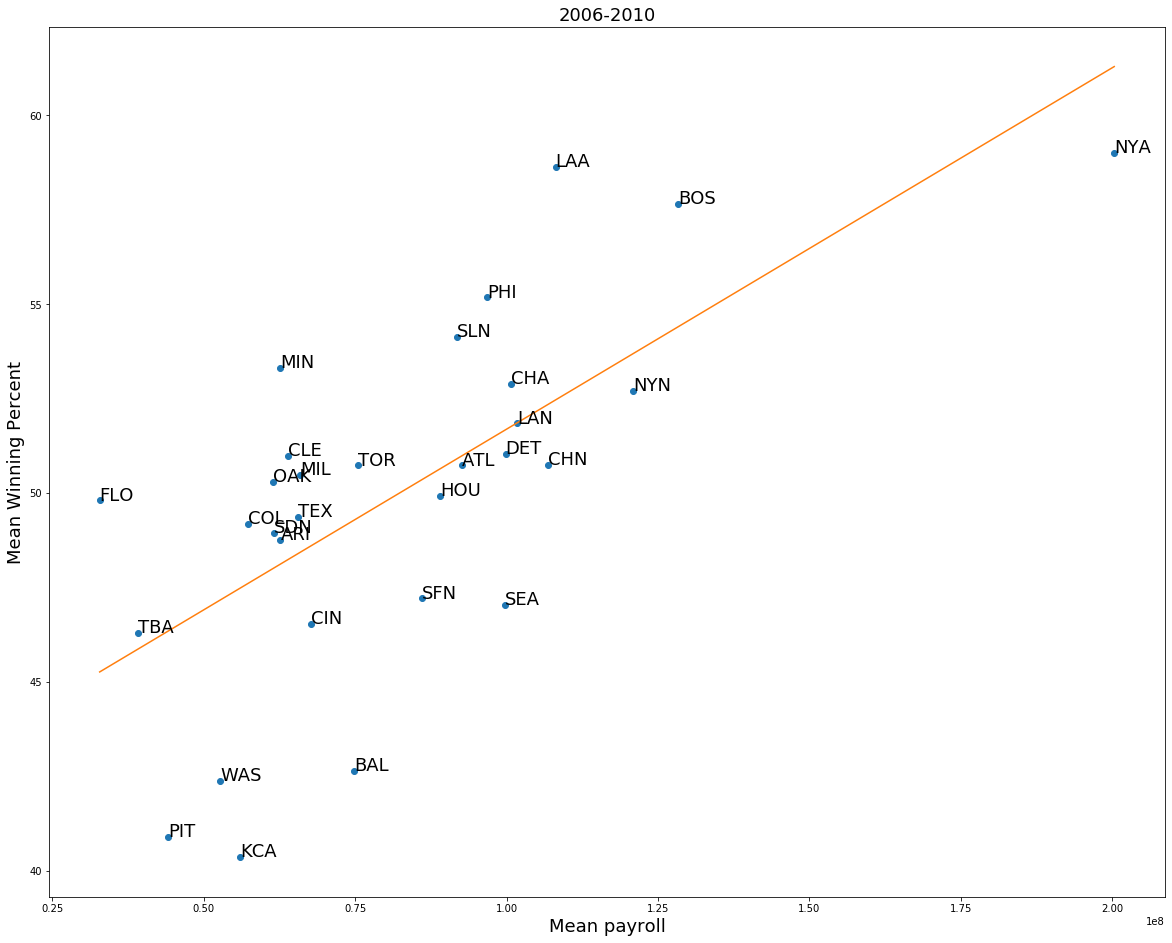

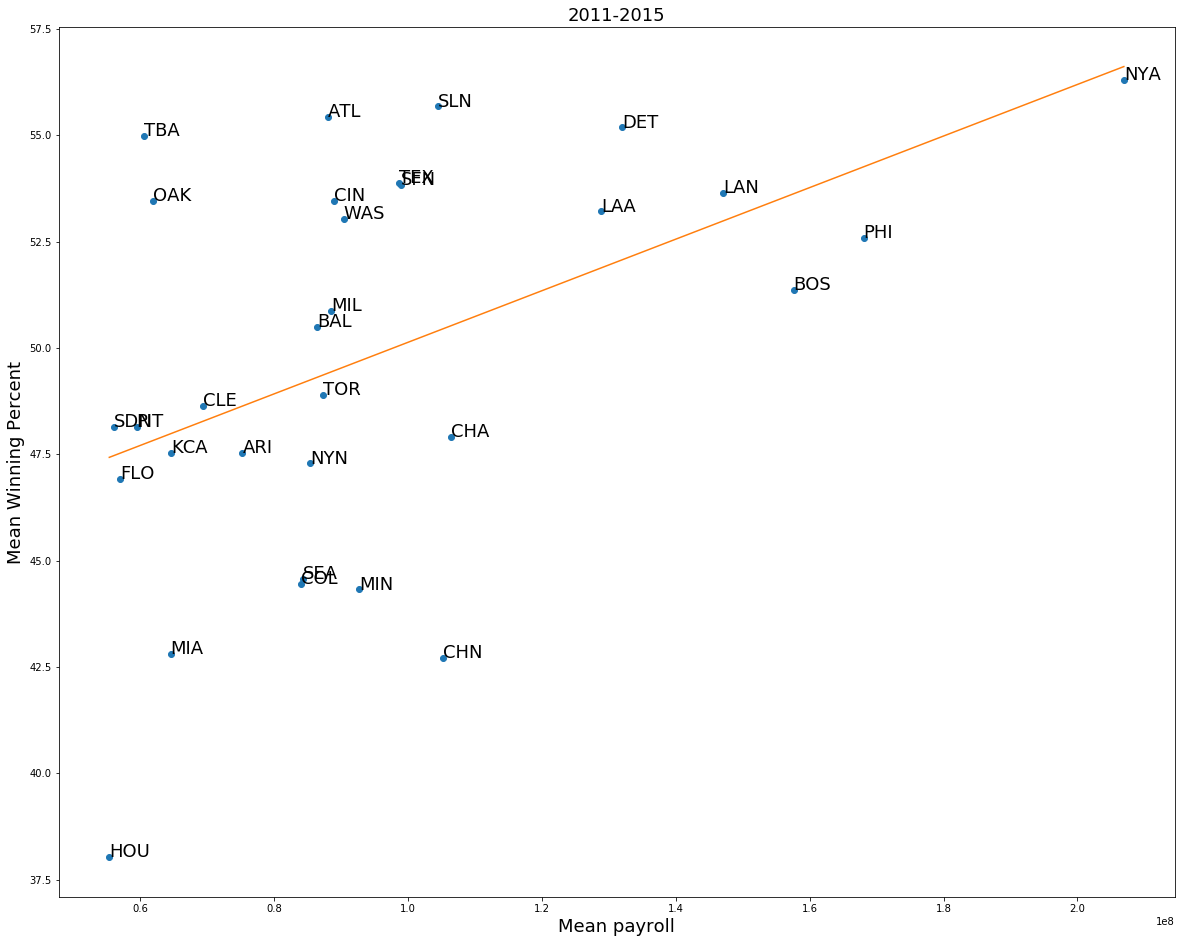

In [15]:
# Problem 4
# 1. First divide data into 5 groups by year and create a new dataframe with data catagorized
# 2. Make a scatterplot showing mean winning percetn and mean payroll of each group with a regression line

years = pd.DataFrame({'yearID':range(1990,2015)}) 
info_needed = years.merge(relations,how = "left", left_on = ['yearID'], right_on = ['yearID'])

bins = [1990,1995,2000,2005,2010,2015]
periods = ['1990-1995','1996-2000','2001-2005','2006-2010','2011-2015']
info_needed['time_period'] = pd.cut(info_needed['yearID'], bins, right=False, labels = periods)

for p in periods:
    # compute mean winning percents and get rid of unnecessary columns
    winning_percents = info_needed.groupby(['time_period']).get_group(p).groupby(['teamID']).sum().reset_index()
    winning_percents["win_percent_by_period"] = 100*winning_percents['all_wins']/winning_percents['all_games']
    winning_percents = winning_percents.drop('yearID',1).drop('total_payroll',1).drop('win_percent',1).drop('all_wins',1).drop('all_games',1)
    
    # compute mean payrolls and get rid of unnecessary columns
    mean_payrolls = info_needed.groupby(['time_period']).get_group(p).groupby(['teamID']).mean().reset_index()
    mean_payrolls["mean_payrolls"] = mean_payrolls['total_payroll']
    mean_payrolls = mean_payrolls.drop('total_payroll',1).drop('yearID',1).drop('win_percent',1).drop('all_wins',1).drop('all_games',1)
    
    # merge the tables above to get a dataframe of all the data we want
    df = winning_percents.merge(mean_payrolls)
    
    # plotting
    payrolls = df['mean_payrolls'].values
    percents = df['win_percent_by_period'].values
    reg = np.polyfit(x = payrolls, y = percents, deg = 1)
    f = np.poly1d(reg)
    x = np.linspace(payrolls.min(), payrolls.max(), 100)
    y = f(x)
    pyplot.figure(figsize=(20,16))
    pyplot.plot(payrolls, percents,'o',x,y)
    pyplot.xlabel("Mean payroll", fontsize = 18)
    pyplot.ylabel("Mean Winning Percent", fontsize = 18)
    pyplot.title(p, fontsize = 18)
    
    # annotate each point with team name
    for i, name in enumerate(df['teamID']):
        pyplot.annotate(name, (payrolls[i], percents[i]), size = 18)


    pyplot.show()
    
# Question 2 
# 1. Generally higher payrolls result in better performance.
# 2. Payrolls increase over time.
# 3. Teams like Oakland which are always above the interpolation line spend their money more cost-effectively.
# 4. Oakland is like a miracle with less money spending - small x value but high winning rates - large y value.
# 5. Team Tor spends less and less money over time while team NYA always spent the most to get high winning rates.
# 6. Team ATL has high winning percent with relatively less money, expect for 2006-2010.

In [16]:
# Part 3
# Problem 5
# 1. First compute the average and standard deviation of payroll for each year.
# 2. Append the two columns to existing data frame.
# 3. Iterate the data frame and compute corresponding std for each row

years = pd.DataFrame({'yearID':range(1990,2015)}) 
payroll_by_year = relations[['yearID','total_payroll']].groupby('yearID')

avg_payroll = years.merge(payroll_by_year.mean(), how = "left", left_on = ['yearID'], right_on = ['yearID']) 
avg_payroll.columns = ['yearID','mean_payroll']

std = years.merge(payroll_by_year.std(), how = "left", left_on = ['yearID'], right_on = ['yearID']) 
std.columns = ['yearID','std']

# Drop unnecessary columns
new_info = info_needed.copy().drop('win_percent',1).drop('all_wins',1).drop('all_games',1).drop('franchID',1)
new_info = new_info.merge(avg_payroll,how = "left", left_on = ['yearID'], right_on = ['yearID']).merge(std,how = "left", left_on = ['yearID'], right_on = ['yearID'])

# Add 'std_payroll' as a new column and then assign values to each row
new_info['std_payroll']  = new_info['total_payroll']
for i, r in new_info.iterrows():
    new_info.at[i, 'std_payroll'] = pd.to_numeric((r['total_payroll'] - r['mean_payroll']) / r['std'])

new_info


,yearID,teamID,total_payroll,time_period,mean_payroll,std,std_payroll
0,1990,ATL,14555501.0,1990-1995,1.707235e+07,3.771834e+06,-0.667275
1,1990,BAL,9680084.0,1990-1995,1.707235e+07,3.771834e+06,-1.959861
2,1990,BOS,20558333.0,1990-1995,1.707235e+07,3.771834e+06,0.924213
3,1990,CAL,21720000.0,1990-1995,1.707235e+07,3.771834e+06,1.232198
4,1990,CHA,9491500.0,1990-1995,1.707235e+07,3.771834e+06,-2.009859
...,...,...,...,...,...,...,...
723,2014,SLN,120693000.0,2011-2015,9.980002e+07,4.570505e+07,0.457126
724,2014,TBA,72689100.0,2011-2015,9.980002e+07,4.570505e+07,-0.593171
725,2014,TEX,112255059.0,2011-2015,9.980002e+07,4.570505e+07,0.272509
726,2014,TOR,109920100.0,2011-2015,9.980002e+07,4.570505e+07,0.221422


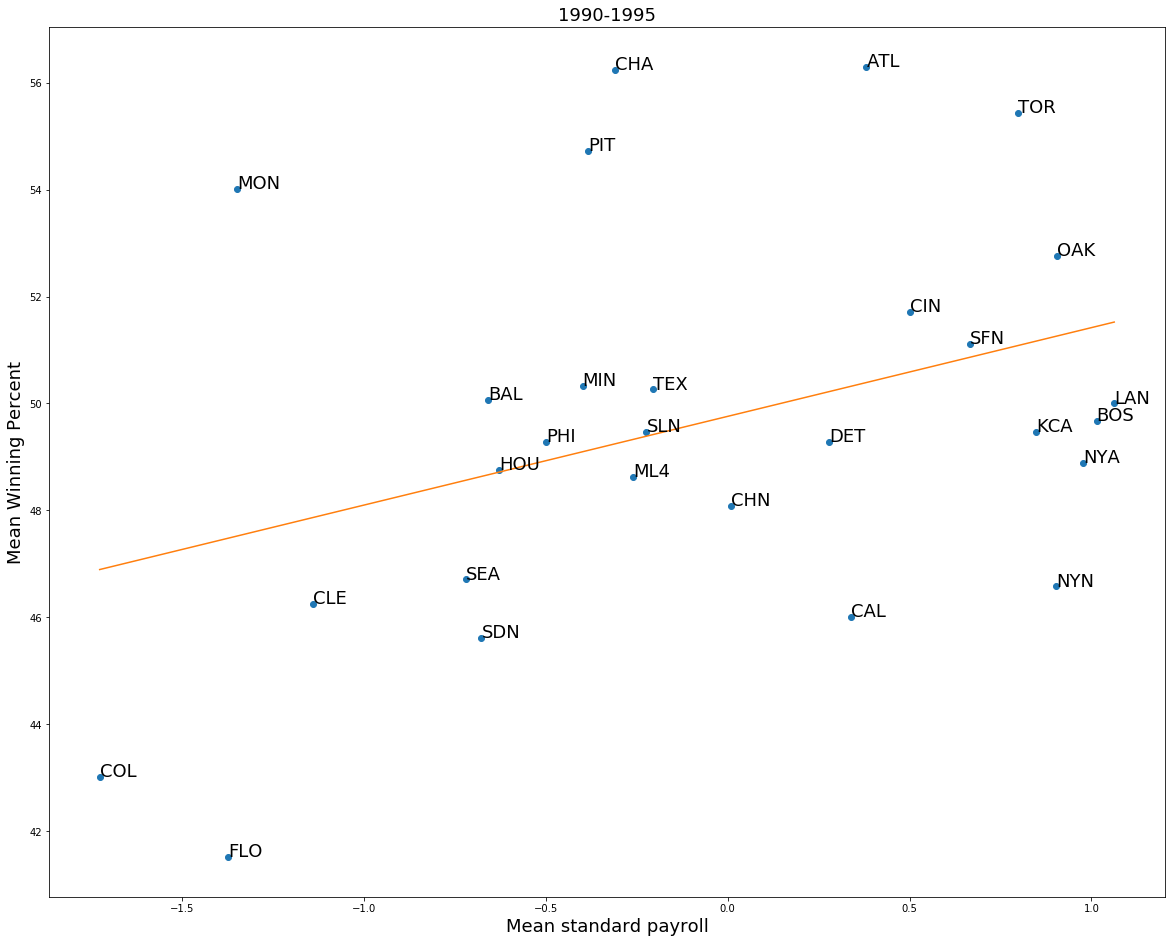

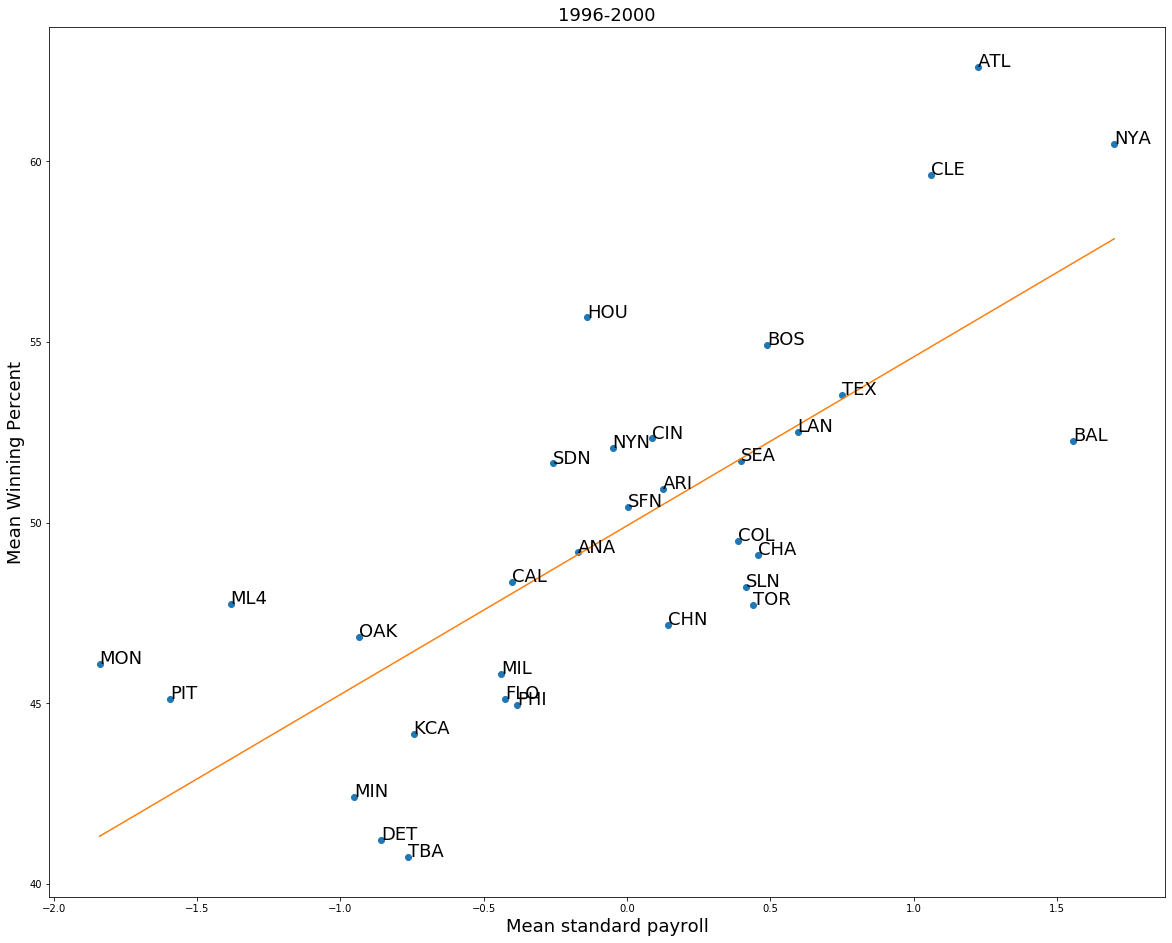

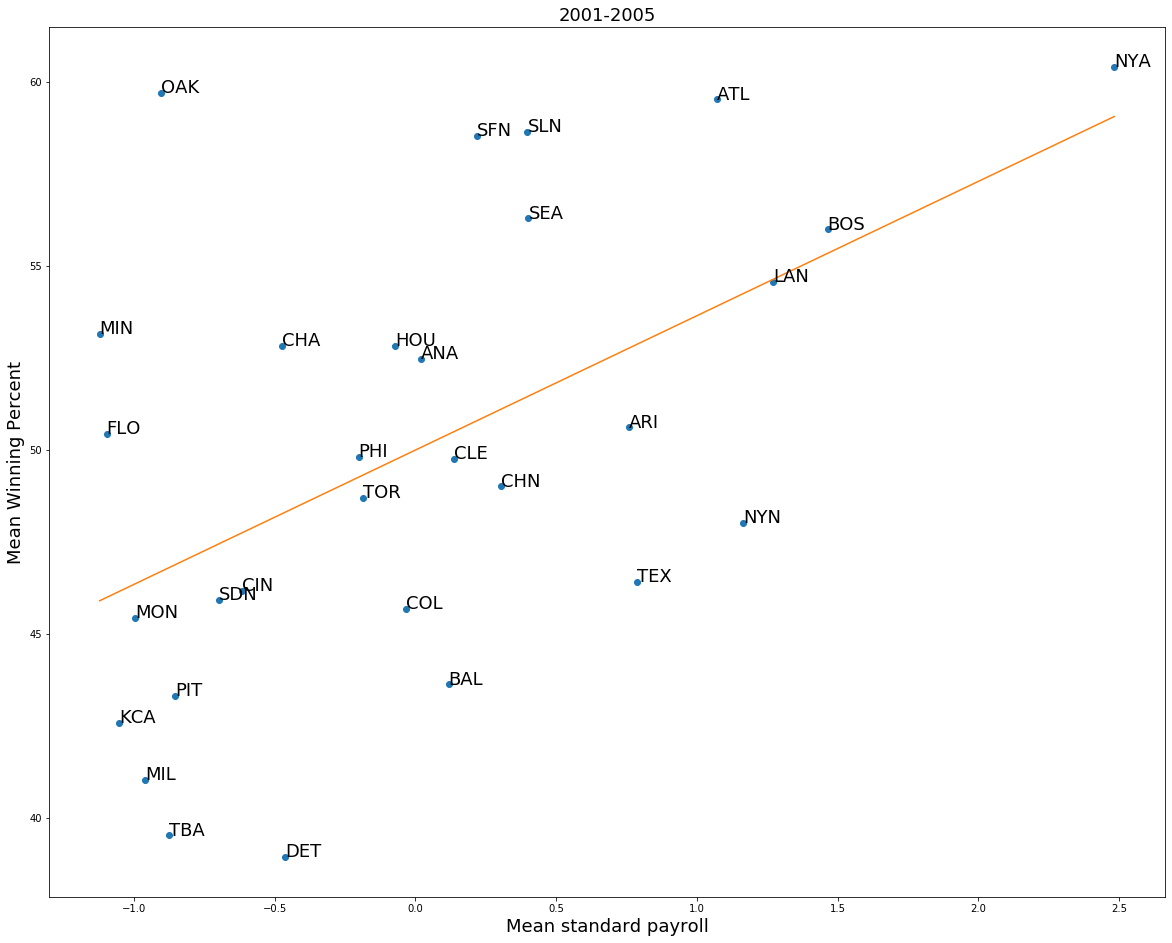

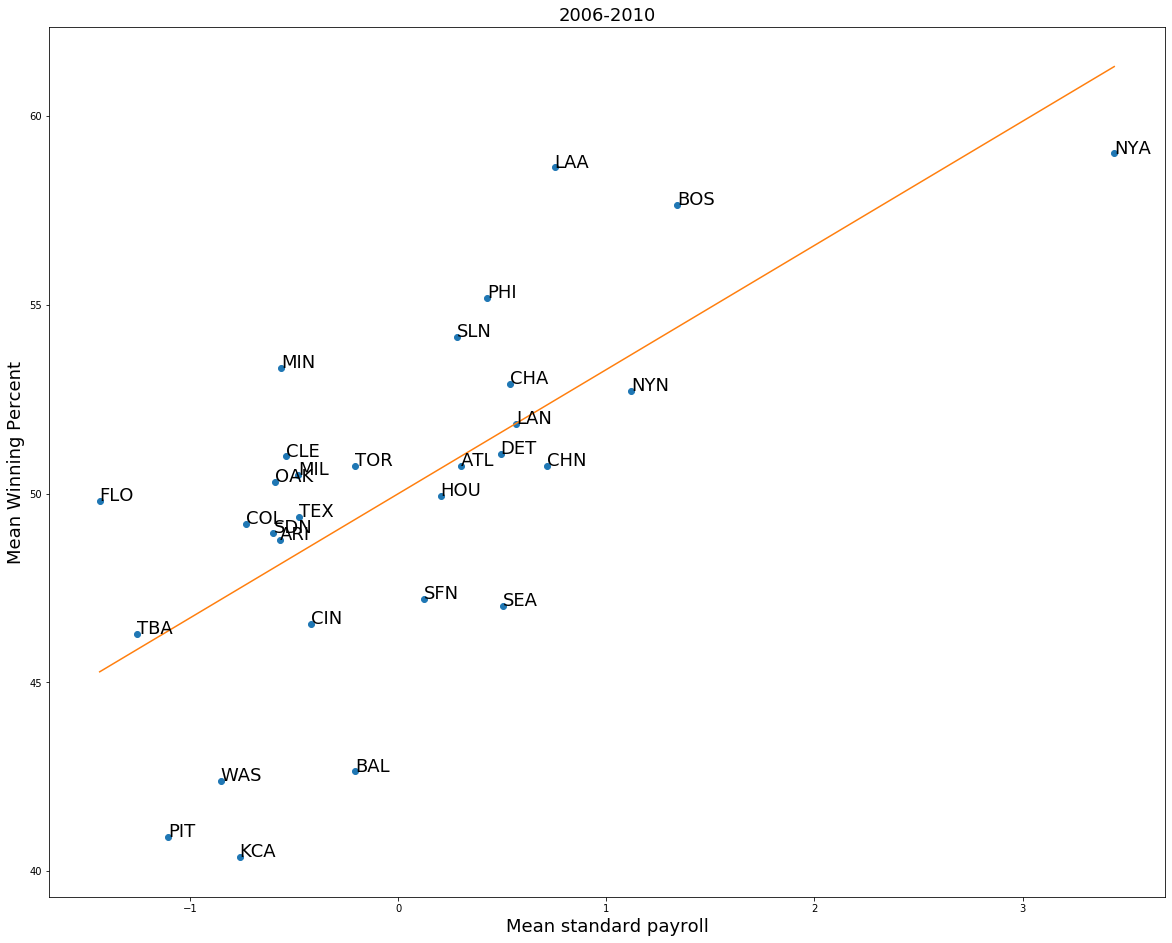

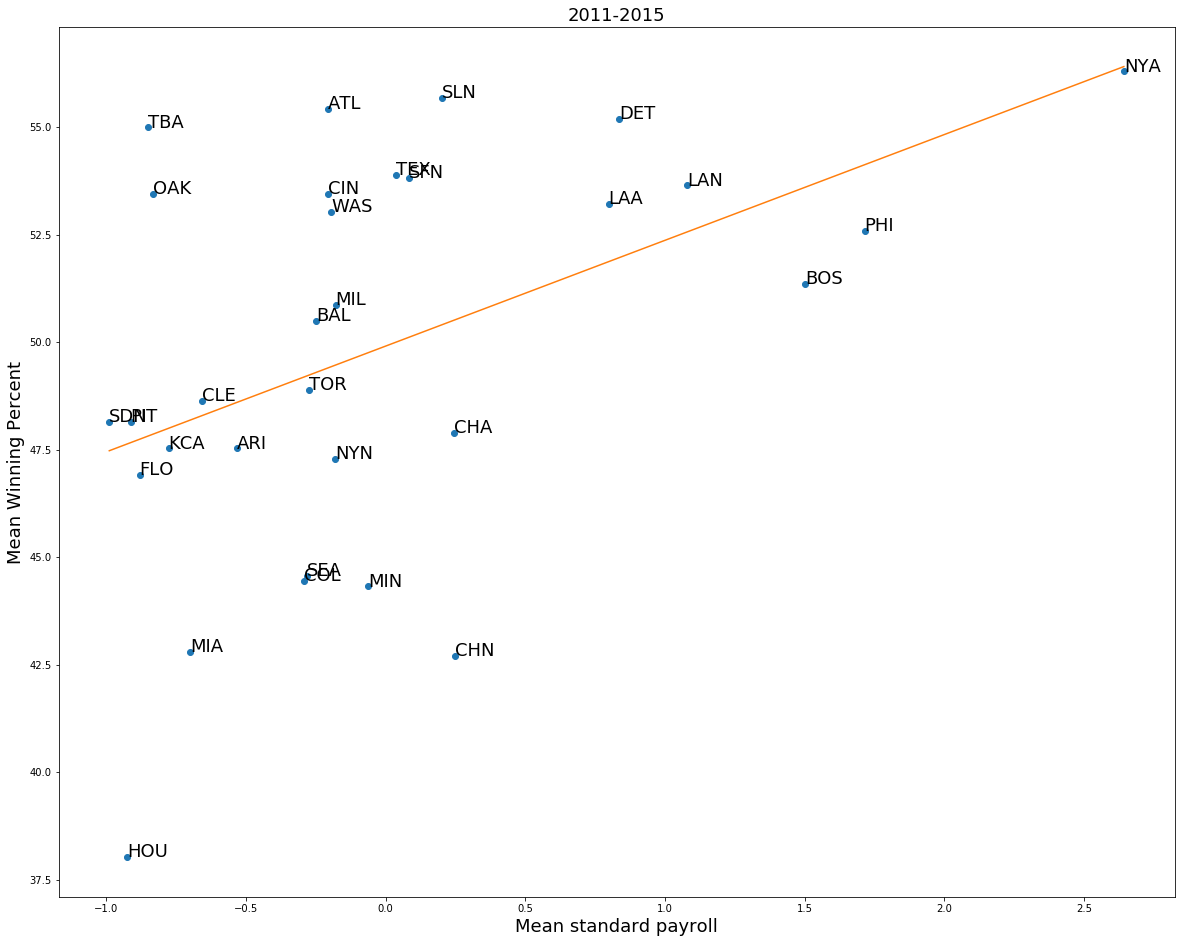

In [17]:
# Problem 6
# Similar plot as Problem 4 using new standardized payroll variable.

for p in periods:
    
    # compute mean winning percents and get rid of unnecessary columns
    winning_percents = info_needed.groupby(['time_period']).get_group(p).groupby(['teamID']).sum().reset_index()
    winning_percents["win_percent_by_period"] = 100*winning_percents['all_wins']/winning_percents['all_games']
    winning_percents = winning_percents.drop('yearID',1).drop('total_payroll',1).drop('win_percent',1).drop('all_wins',1).drop('all_games',1)
   
    # compute mean standard payrolls and get rid of unnecessary columns
    mean_std_payrolls = new_info.groupby(['time_period']).get_group(p).drop('yearID',1).drop('total_payroll',1).drop('mean_payroll', 1).drop('std',1)
    mean_std_payrolls = mean_std_payrolls.drop('time_period',1).groupby(['teamID']).mean().reset_index()
    mean_std_payrolls.columns=['teamID','mean_std_payroll']
    
    # merge the tables above to get a dataframe of all the data we want
    df = winning_percents.merge(mean_std_payrolls)
     
    # plotting
    payrolls = df['mean_std_payroll'].values
    percents = df['win_percent_by_period'].values
    reg = np.polyfit(x = payrolls, y = percents, deg = 1)
    f = np.poly1d(reg)
    x = np.linspace(payrolls.min(), payrolls.max(), 100)
    y = f(x)
    pyplot.figure(figsize=(20,16))
    pyplot.plot(payrolls, percents,'o',x,y)
    pyplot.xlabel("Mean standard payroll", fontsize = 18)
    pyplot.ylabel("Mean Winning Percent", fontsize = 18)
    pyplot.title(p, fontsize = 18)
    
    # annotate each point with team name
    for i, name in enumerate(df['teamID']):
        pyplot.annotate(name, (payrolls[i], percents[i]), size = 18)


    pyplot.show()

# Question 3
# The general trend and distribution is similar in two graphs. However, in the graph below,
# the distribution is closer to the regression line. Overall, the graph reflects data more obviously or "intensely".


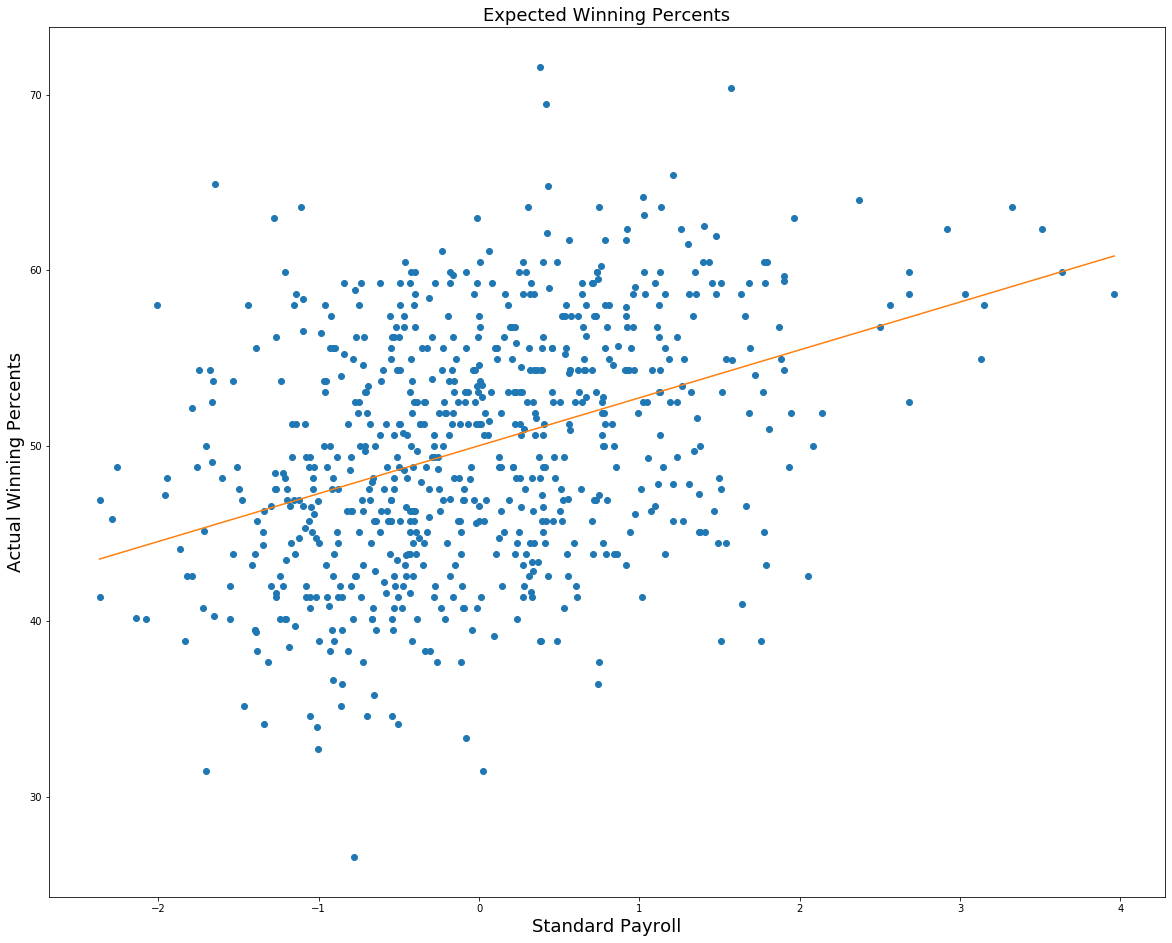

,yearID,teamID,total_payroll,std_payroll,win_percent,exp_win_percent
0,1990,ATL,14555501.0,-0.667275,40.123457,48.331811
1,1990,BAL,9680084.0,-1.959861,47.204969,45.100348
2,1990,BOS,20558333.0,0.924213,54.320988,52.310533
3,1990,CAL,21720000.0,1.232198,49.382716,53.080495
4,1990,CHA,9491500.0,-2.009859,58.024691,44.975353
...,...,...,...,...,...,...
723,2014,SLN,120693000.0,0.457126,55.555556,51.142816
724,2014,TBA,72689100.0,-0.593171,47.530864,48.517072
725,2014,TEX,112255059.0,0.272509,41.358025,50.681273
726,2014,TOR,109920100.0,0.221422,51.234568,50.553554


In [18]:
# Problem 7
# 1. "Cut" and merge existing dataframes to get one with all the data we want
# 2. Compute expecting winning percentage using formulas given
# 3. Plot the graph for all the distribution

df7 = info_needed.copy().drop('all_wins',1).drop('all_games',1).drop('franchID',1).drop('time_period',1).drop('win_percent',1)
df7['std_payroll'] = new_info['std_payroll']
df7['win_percent'] = info_needed['win_percent']
df7['exp_win_percent'] = df7['std_payroll']*2.5 + 50

#plot the expected_win% graph
payrolls = df7['std_payroll'].values
percents = df7['win_percent'].values
reg = np.polyfit(x = payrolls, y = percents, deg=1)
f = np.poly1d(reg)
x = np.linspace(payrolls.min(), payrolls.max(), 100)
y = f(x)
pyplot.figure(figsize = (20,16))
pyplot.plot(payrolls, percents,'o', x, y)


pyplot.xlabel("Standard Payroll", fontsize = 18)
pyplot.ylabel("Actual Winning Percents", fontsize = 18)
pyplot.title("Expected Winning Percents", fontsize = 18)

pyplot.show()
df7

Text(0, 0.5, 'Efficiencies')

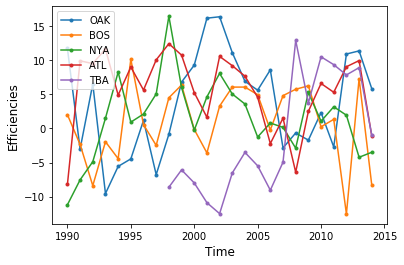

In [19]:
# Problem 8
# 1. Get a new data frame with all the data we need from previous data frame.
# 2. Get rid of data of other teams we don't want
# 3. Plot the graphs we want
df8 = df7.drop('total_payroll',1).drop('std_payroll',1)
df8['efficiency'] = df8['win_percent'] - df8['exp_win_percent']

examples = ['OAK','BOS','NYA','ATL','TBA']

for i in examples:
    values = df8[df8['teamID'] == i].sort_values(['yearID'])
    x = values['yearID']
    y = values['efficiency'].fillna(value = 0)
    pyplot.plot(x, y, marker = '.', label = i)
    

pyplot.legend() 
pyplot.xlabel('Time',fontsize=12) 
pyplot.ylabel('Efficiencies',fontsize = 12) 

# Question 4
# While the graphs show the efficiency of money spent by five teams listed above, we can see that those five teams
# have a positive efficiency for most of the time while TBA probably did the worst among them.
# For Oakland, we can see that it was doing well generally, with a peak aroung 2002-2003.
# Compared with lots in Question 2 and 3, only this graph enables me to see the efficiency of the spending of these teams
# as well as how efficiencies change over time.